## HF/LF analysis

See vsb_analyze-power-line-signals_parallel.py for HF/LF signal division

In [1]:
import csv
import numpy as np
from scipy.interpolate import interp1d
from scipy import fftpack, signal
from scipy.signal import butter, filtfilt, hilbert
from scipy.signal import sosfilt, sosfreqz
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import pickle
import re
import random

In [2]:
import datashader as ds
from datashader import transfer_functions as tf

In [3]:
period = 0.02
time_step = 0.02 / 800000.
time_vec = np.arange(0, 0.02, time_step)
f_sampling = 1 / time_step
print(f'Sampling Frequency = {f_sampling / 1e6} MHz')
# print (str(50* 800000 /1e6) + ' MHz')

Sampling Frequency = 40.0 MHz


Read signals (variable x). 
I would like to thank https://www.kaggle.com/xhlulu/exploring-signal-processing-with-scipy and the host: https://www.kaggle.com/sohier/reading-the-data-with-python

### Recombine signals

In [ ]:
df_hf = pq.read_table(data_bp+'train_hf_sig.parquet').to_pandas()

In [ ]:
df_lf = pq.read_table(data_bp+'train_lf_sig.parquet').to_pandas()

In [ ]:
# Fetch one signal from xs
idx = 1
sig = df_lf.iloc[:, idx]
idx_error = 3
sig_error = df_lf.iloc[:, idx_error]
print(sig.shape)

In [ ]:
sig_fft = fftpack.fft(sig)

In [ ]:
bad_hf = pq.read_table(f'../input/bp_signals/bad_hf_sig.parquet').to_pandas()

In [ ]:
# Fetch one hf signal
idx = 1
sig_hf = bad_hf.iloc[:, idx]
idx_error = 3
sig_hf_error = bad_hf.iloc[:, idx_error]
print(sig_hf.shape)

In [ ]:
sig_hf = bad_hf['3']

In [ ]:
sig_lf = df_lf['3']

In [12]:
rec_sig = sig+sig_hf

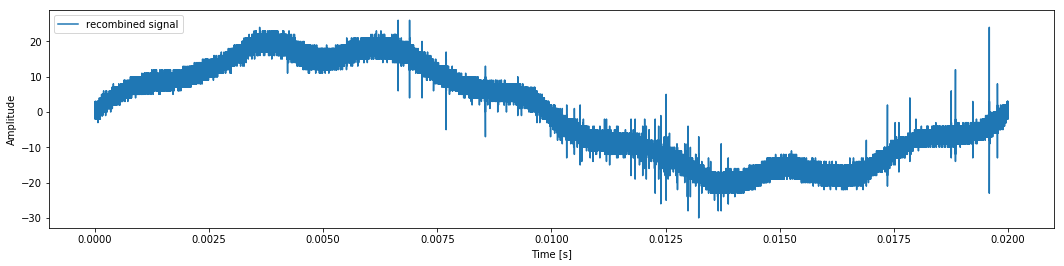

In [14]:
plt.figure(figsize=(18,4))
plt.plot(time_vec, rec_sig, label='recombined signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

In [17]:
lf_sigs=[]
#first 100 LF signals
for idx in range(100):
    lf_sigs.append(df_lf.iloc[:, idx])

Text(0, 0.5, 'Amplitude')

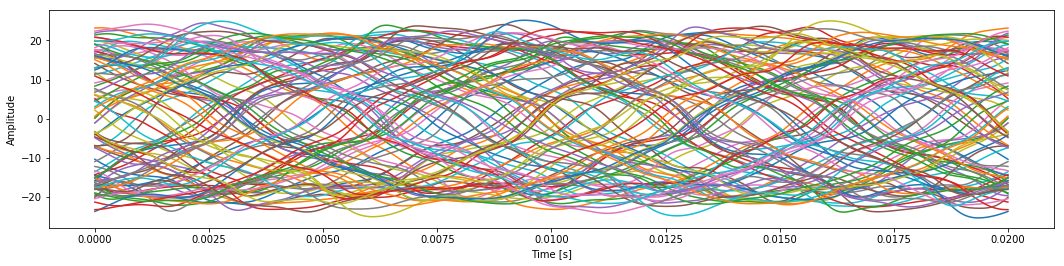

In [18]:
plt.figure(figsize=(18,4))
for lf_sig in lf_sigs:
    plt.plot(time_vec, lf_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


In [ ]:
### Signals start at any part of cycle

In [19]:
hf_sigs=[]
#first 100 HF signals
for idx in range(100):
    hf_sigs.append(df_hf.iloc[:, idx])

Text(0, 0.5, 'Amplitude')

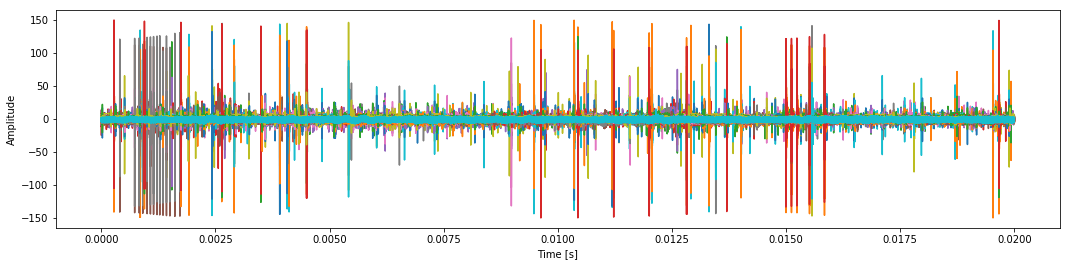

In [20]:
plt.figure(figsize=(18,4))
for hf_sig in hf_sigs:
    plt.plot(time_vec, hf_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

### Only bag signals

train_meta_error

In [24]:
bad100 = train_meta_error.iloc[:, :100]

In [26]:
bad_sigs=bad100.signal_id.values

In [29]:
df_hf.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,-1.048705,0.786055,0.179286,-1.001802,-0.186245,-0.775627,-0.417712,-2.361912,0.079016,-2.470254,...,-0.000443,-2.190860,-2.162223,0.574183,-0.583502,-0.670861,-2.003877,-1.862254,-1.132162,-1.795980
1,-1.048605,-0.214229,0.179465,-2.001965,-1.186059,-0.775649,-2.417578,-1.361792,1.078762,-1.470414,...,-1.000363,-1.190839,-2.162138,0.574084,0.416480,0.329202,-0.003919,-1.862355,-0.131924,-0.796107


In [30]:
hf_sigs=[]
#100 bad HF signals
for i in bad_sigs:
    c=df_hf.iloc[:, i]
    hf_sigs.append(c)

Text(0, 0.5, 'Amplitude')

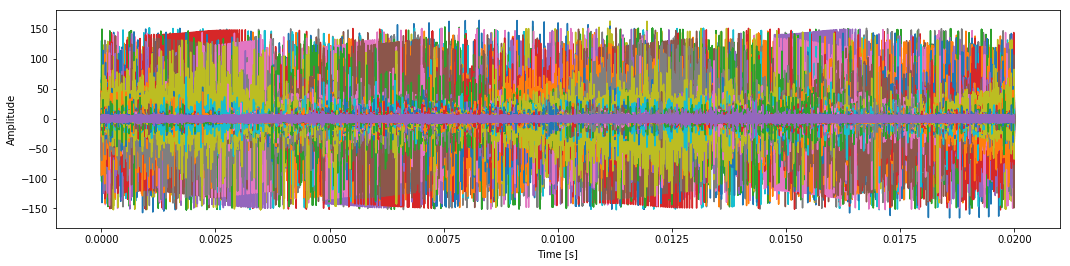

In [31]:
plt.figure(figsize=(18,4))
for hf_sig in hf_sigs:
    plt.plot(time_vec, hf_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

### only good HF signals


In [5]:
good = train_meta_good.iloc[:, :20]

In [6]:
good_sigs=good.signal_id.values

In [7]:
len(good_sigs)

8187

In [ ]:
hf_sigs=[]
for i in good_sigs:
    c=df_hf.iloc[:, i]
    hf_sigs.append(c)

In [ ]:
#free mem
df_hf=None
train_meta_good=None


In [ ]:
plt.figure(figsize=(18,4))
for hf_sig in hf_sigs:
    plt.plot(time_vec, hf_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

### get good / bad as new df

In [8]:
good_ids=list(train_meta_good.signal_id.values)

In [19]:
good_ids = [str(x) for x in good_ids]

In [20]:
type(list(df_hf)[0])

str

In [22]:
hf_good=df_hf.loc[:, df_hf.columns.isin(good_ids)]

In [24]:
hf_good.shape

(800000, 8187)

In [27]:
hf_good.to_parquet(f'../input/bp_signals/good_hf_sig.parquet')

In [29]:
bad_ids=list(train_meta_error.signal_id.values)
bad_ids = [str(x) for x in bad_ids]

In [30]:
hf_bad=df_hf.loc[:, df_hf.columns.isin(bad_ids)]
hf_bad.shape

(800000, 525)

In [31]:
hf_bad.to_parquet(f'../input/bp_signals/bad_hf_sig.parquet')